STEP 1: IMPORT LIBRARIES

In [ ]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, roc_auc_score, roc_curve
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.utils import resample
import warnings
warnings.filterwarnings('ignore')

In [ ]:
plt.style.use('seaborn-v0_8')
sns.set_palette("husl")

STEP 2:LOAD DATASET

In [ ]:
data = pd.read_csv("/content/school_dropout_data_with_features.csv")
print("Dataset shape:", data.shape)
print("\nFirst few rows:")
print(data.head())

Dataset shape: (300, 15)

First few rows:
  Student_ID               School         Area  Gender    Caste  Standard  \
0     STD923  Govt Primary School  Rajajinagar  Female       SC         8   
1     STD570  Govt Primary School       Hebbal    Male      OBC        12   
2     STD652     Govt High School  Malleswaram    Male       ST         7   
3     STD967     Govt High School  Rajajinagar    Male  General         5   
4     STD404     Govt High School       Hebbal    Male      OBC        10   

   Age  Attendance  Previous_Score Parental_Education Family_Income  \
0   13          88              53                NaN           Low   
1   17          78              83             Higher        Medium   
2   12          64              62            Primary           Low   
3   10          92              53           Graduate          High   
4   15          57              65             Higher           Low   

  Scholarship  Distance Special_Care    Parent_Type  
0         Yes 

STEP 3: RULE BASED LABELLING

In [ ]:
def assign_dropout_enhanced(row):
    risk_score = 0

    if row["Attendance"] < 50:
        risk_score += 4
    elif row["Attendance"] < 65:
        risk_score += 3
    elif row["Attendance"] < 80:
        risk_score += 2
    elif row["Attendance"] < 90:
        risk_score += 1

    if row["Previous_Score"] < 35:
        risk_score += 4
    elif row["Previous_Score"] < 50:
        risk_score += 3
    elif row["Previous_Score"] < 65:
        risk_score += 2
    elif row["Previous_Score"] < 75:
        risk_score += 1

    if row["Parental_Education"] in ["None"]:
        risk_score += 3
    elif row["Parental_Education"] == "Primary":
        risk_score += 2
    elif row["Parental_Education"] == "Secondary":
        risk_score += 1

    if row["Family_Income"] == "Low":
        risk_score += 3
    elif row["Family_Income"] == "Medium":
        risk_score += 1

    if row["Distance"] > 20:
        risk_score += 3
    elif row["Distance"] > 12:
        risk_score += 2
    elif row["Distance"] > 8:
        risk_score += 1

    if row["Special_Care"] == "Disability":
        risk_score += 2
    elif row["Special_Care"] == "Minority":
        risk_score += 1

    if row["Parent_Type"] == "Orphan":
        risk_score += 4
    elif row["Parent_Type"] == "Single Parent":
        risk_score += 2

    age_standard_gap = row["Age"] - row["Standard"] - 5
    if age_standard_gap > 3:
        risk_score += 3
    elif age_standard_gap > 1:
        risk_score += 2
    elif age_standard_gap > 0:
        risk_score += 1

    if row["Standard"] >= 10:
        risk_score += 2
    elif row["Standard"] >= 8:
        risk_score += 1

    if row["Scholarship"] == "No":
        risk_score += 1

    if row["Area"] == "Rural":
        risk_score += 1

    return 1 if risk_score >= 8 else 0

data["Dropout"] = data.apply(assign_dropout_enhanced, axis=1)

STEP 4: DATA PROCESSING

In [ ]:
data['Age_Standard_Gap'] = data['Age'] - data['Standard'] - 5
data['Attendance_Score_Interaction'] = data['Attendance'] * data['Previous_Score'] / 100
data['Financial_Stress'] = ((data['Family_Income'] == 'Low') & (data['Scholarship'] == 'No')).astype(int)

print("\nDropout distribution after enhanced labeling:")
dropout_dist = data["Dropout"].value_counts(normalize=True)
print(dropout_dist)

if dropout_dist.min() < 0.3:
    print("\nHandling class imbalance...")
    df_majority = data[data.Dropout == 0]
    df_minority = data[data.Dropout == 1]

    df_minority_upsampled = resample(df_minority,
                                   replace=True,
                                   n_samples=len(df_majority)//2,
                                   random_state=42)

    data_balanced = pd.concat([df_majority, df_minority_upsampled])
    data = data_balanced.sample(frac=1, random_state=42).reset_index(drop=True)
    print("New dropout distribution:", data["Dropout"].value_counts(normalize=True))

feature_columns = [col for col in data.columns if col not in ["Student_ID", "Dropout"]]
X = data[feature_columns].copy()
y = data["Dropout"]

categorical_columns = X.select_dtypes(include=['object']).columns
label_encoders = {}

for col in categorical_columns:
    le = LabelEncoder()
    X[col] = le.fit_transform(X[col])
    label_encoders[col] = le

numerical_columns = X.select_dtypes(include=[np.number]).columns
scaler = StandardScaler()
X[numerical_columns] = scaler.fit_transform(X[numerical_columns])


Dropout distribution after enhanced labeling:
Dropout
1    0.793333
0    0.206667
Name: proportion, dtype: float64

Handling class imbalance...
New dropout distribution: Dropout
0    0.666667
1    0.333333
Name: proportion, dtype: float64


STEP 5: SPLITTING THE DATASET

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

STEP 6: TRAINING THE MODEL

In [ ]:
rf_params = {
    'n_estimators': [100, 200],
    'max_depth': [10, 15, None],
    'min_samples_split': [2, 5],
    'min_samples_leaf': [1, 2]
}

rf_model = RandomForestClassifier(random_state=42)
rf_grid = GridSearchCV(rf_model, rf_params, cv=5, scoring='roc_auc', n_jobs=-1)
rf_grid.fit(X_train, y_train)

print("Best Random Forest parameters:", rf_grid.best_params_)
best_rf = rf_grid.best_estimator_

gb_model = GradientBoostingClassifier(random_state=42, learning_rate=0.1, n_estimators=100)
gb_model.fit(X_train, y_train)

models = {
    'Random Forest': best_rf,
    'Gradient Boosting': gb_model
}

print("\nMODEL EVALUATION -")

for name, model in models.items():
    cv_scores = cross_val_score(model, X_train, y_train, cv=5, scoring='roc_auc')

    y_pred = model.predict(X_test)
    y_pred_proba = model.predict_proba(X_test)[:, 1]

    print(f"\n{name}:")
    print(f"Cross-validation AUC: {cv_scores.mean():.4f} (+/- {cv_scores.std() * 2:.4f})")
    print(f"Test Accuracy: {accuracy_score(y_test, y_pred):.4f}")
    print(f"Test AUC: {roc_auc_score(y_test, y_pred_proba):.4f}")

final_model = best_rf

Best Random Forest parameters: {'max_depth': 10, 'min_samples_leaf': 1, 'min_samples_split': 5, 'n_estimators': 200}

MODEL EVALUATION -

Random Forest:
Cross-validation AUC: 0.8280 (+/- 0.1148)
Test Accuracy: 0.7895
Test AUC: 0.8333

Gradient Boosting:
Cross-validation AUC: 0.8160 (+/- 0.1114)
Test Accuracy: 0.6316
Test AUC: 0.7821


STEP 7: VISULAIZATION

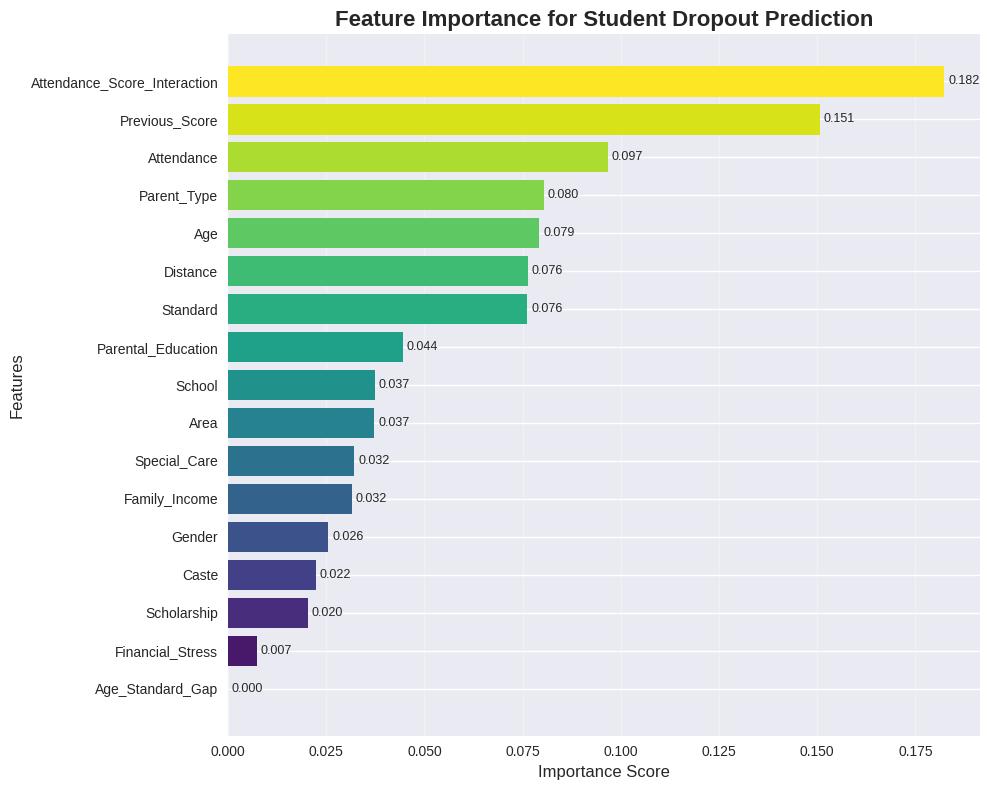

In [ ]:
feature_importance = pd.DataFrame({
    'feature': X.columns,
    'importance': final_model.feature_importances_
}).sort_values('importance', ascending=True)

plt.figure(figsize=(10, 8))
colors = plt.cm.viridis(np.linspace(0, 1, len(feature_importance)))
bars = plt.barh(feature_importance['feature'], feature_importance['importance'], color=colors)
plt.title('Feature Importance for Student Dropout Prediction', fontsize=16, fontweight='bold')
plt.xlabel('Importance Score', fontsize=12)
plt.ylabel('Features', fontsize=12)
plt.grid(axis='x', alpha=0.3)

for i, bar in enumerate(bars):
    plt.text(bar.get_width() + 0.001, bar.get_y() + bar.get_height()/2,
             f'{feature_importance.iloc[i]["importance"]:.3f}',
             ha='left', va='center', fontsize=9)

plt.tight_layout()
plt.show()

In [ ]:
def plot_categorical_enhanced(feature, data_source=data):
    plt.figure(figsize=(10, 6))

    dropout_rates = data_source.groupby(feature)['Dropout'].agg(['mean', 'count']).reset_index()
    dropout_rates.columns = [feature, 'dropout_rate', 'count']

    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))

    colors = sns.color_palette("Set2", len(dropout_rates))
    bars1 = ax1.bar(dropout_rates[feature], dropout_rates['dropout_rate'], color=colors)
    ax1.set_title(f'Dropout Rate by {feature}', fontsize=14, fontweight='bold')
    ax1.set_ylabel('Dropout Rate', fontsize=12)
    ax1.set_xlabel(feature, fontsize=12)
    ax1.grid(axis='y', alpha=0.3)

    for bar, rate in zip(bars1, dropout_rates['dropout_rate']):
        ax1.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.01,
                f'{rate:.1%}', ha='center', va='bottom', fontweight='bold')

    bars2 = ax2.bar(dropout_rates[feature], dropout_rates['count'], color=colors, alpha=0.7)
    ax2.set_title(f'Sample Count by {feature}', fontsize=14, fontweight='bold')
    ax2.set_ylabel('Count', fontsize=12)
    ax2.set_xlabel(feature, fontsize=12)
    ax2.grid(axis='y', alpha=0.3)

    for bar, count in zip(bars2, dropout_rates['count']):
        ax2.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.5,
                f'{int(count)}', ha='center', va='bottom', fontweight='bold')

    plt.tight_layout()
    plt.show()

In [ ]:
def plot_numerical_enhanced(feature, bins=6, data_source=data):
    fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(15, 12))

    binned = pd.cut(data_source[feature], bins=bins, precision=1)
    dropout_by_bin = data_source.groupby(binned)['Dropout'].agg(['mean', 'count']).reset_index()
    dropout_by_bin['bin_label'] = dropout_by_bin[feature].astype(str)

    colors = plt.cm.plasma(np.linspace(0, 1, len(dropout_by_bin)))
    bars1 = ax1.bar(range(len(dropout_by_bin)), dropout_by_bin['mean'], color=colors)
    ax1.set_title(f'Dropout Rate by {feature} (Binned)', fontsize=14, fontweight='bold')
    ax1.set_ylabel('Dropout Rate', fontsize=12)
    ax1.set_xlabel(f'{feature} Ranges', fontsize=12)
    ax1.set_xticks(range(len(dropout_by_bin)))
    ax1.set_xticklabels(dropout_by_bin['bin_label'], rotation=45, ha='right')
    ax1.grid(axis='y', alpha=0.3)

    for i, (bar, rate) in enumerate(zip(bars1, dropout_by_bin['mean'])):
        ax1.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.01,
                f'{rate:.1%}', ha='center', va='bottom', fontweight='bold', fontsize=10)

    ax2.hist(data_source[data_source['Dropout']==0][feature], bins=20, alpha=0.6,
             label='No Dropout', color='lightblue', density=True)
    ax2.hist(data_source[data_source['Dropout']==1][feature], bins=20, alpha=0.6,
             label='Dropout', color='salmon', density=True)
    ax2.set_title(f'Distribution of {feature} by Dropout Status', fontsize=14, fontweight='bold')
    ax2.set_xlabel(feature, fontsize=12)
    ax2.set_ylabel('Density', fontsize=12)
    ax2.legend()
    ax2.grid(alpha=0.3)

    dropout_data = [data_source[data_source['Dropout']==0][feature].dropna(),
                   data_source[data_source['Dropout']==1][feature].dropna()]

    bp = ax3.boxplot(dropout_data, labels=['No Dropout', 'Dropout'], patch_artist=True,
                     boxprops=dict(facecolor='lightblue', color='navy', linewidth=2),
                     medianprops=dict(color='red', linewidth=2),
                     whiskerprops=dict(color='navy', linewidth=2),
                     capprops=dict(color='navy', linewidth=2),
                     flierprops=dict(marker='o', markerfacecolor='orange', markersize=5, alpha=0.7))

    colors = ['lightblue', 'lightcoral']
    for patch, color in zip(bp['boxes'], colors):
        patch.set_facecolor(color)
        patch.set_alpha(0.7)

    ax3.set_title(f'{feature} by Dropout Status (Box Plot)', fontsize=14, fontweight='bold')
    ax3.set_xlabel('Dropout Status', fontsize=12)
    ax3.set_ylabel(feature, fontsize=12)
    ax3.grid(True, alpha=0.3)

    bars4 = ax4.bar(range(len(dropout_by_bin)), dropout_by_bin['count'],
                    color=colors, alpha=0.7)
    ax4.set_title(f'Sample Count by {feature} Bins', fontsize=14, fontweight='bold')
    ax4.set_ylabel('Count', fontsize=12)
    ax4.set_xlabel(f'{feature} Ranges', fontsize=12)
    ax4.set_xticks(range(len(dropout_by_bin)))
    ax4.set_xticklabels(dropout_by_bin['bin_label'], rotation=45, ha='right')
    ax4.grid(axis='y', alpha=0.3)

    for bar, count in zip(bars4, dropout_by_bin['count']):
        ax4.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.5,
                f'{int(count)}', ha='center', va='bottom', fontweight='bold', fontsize=10)

    plt.tight_layout()
    plt.show()


GENERATING ENHANCED VISUALIZATIONS



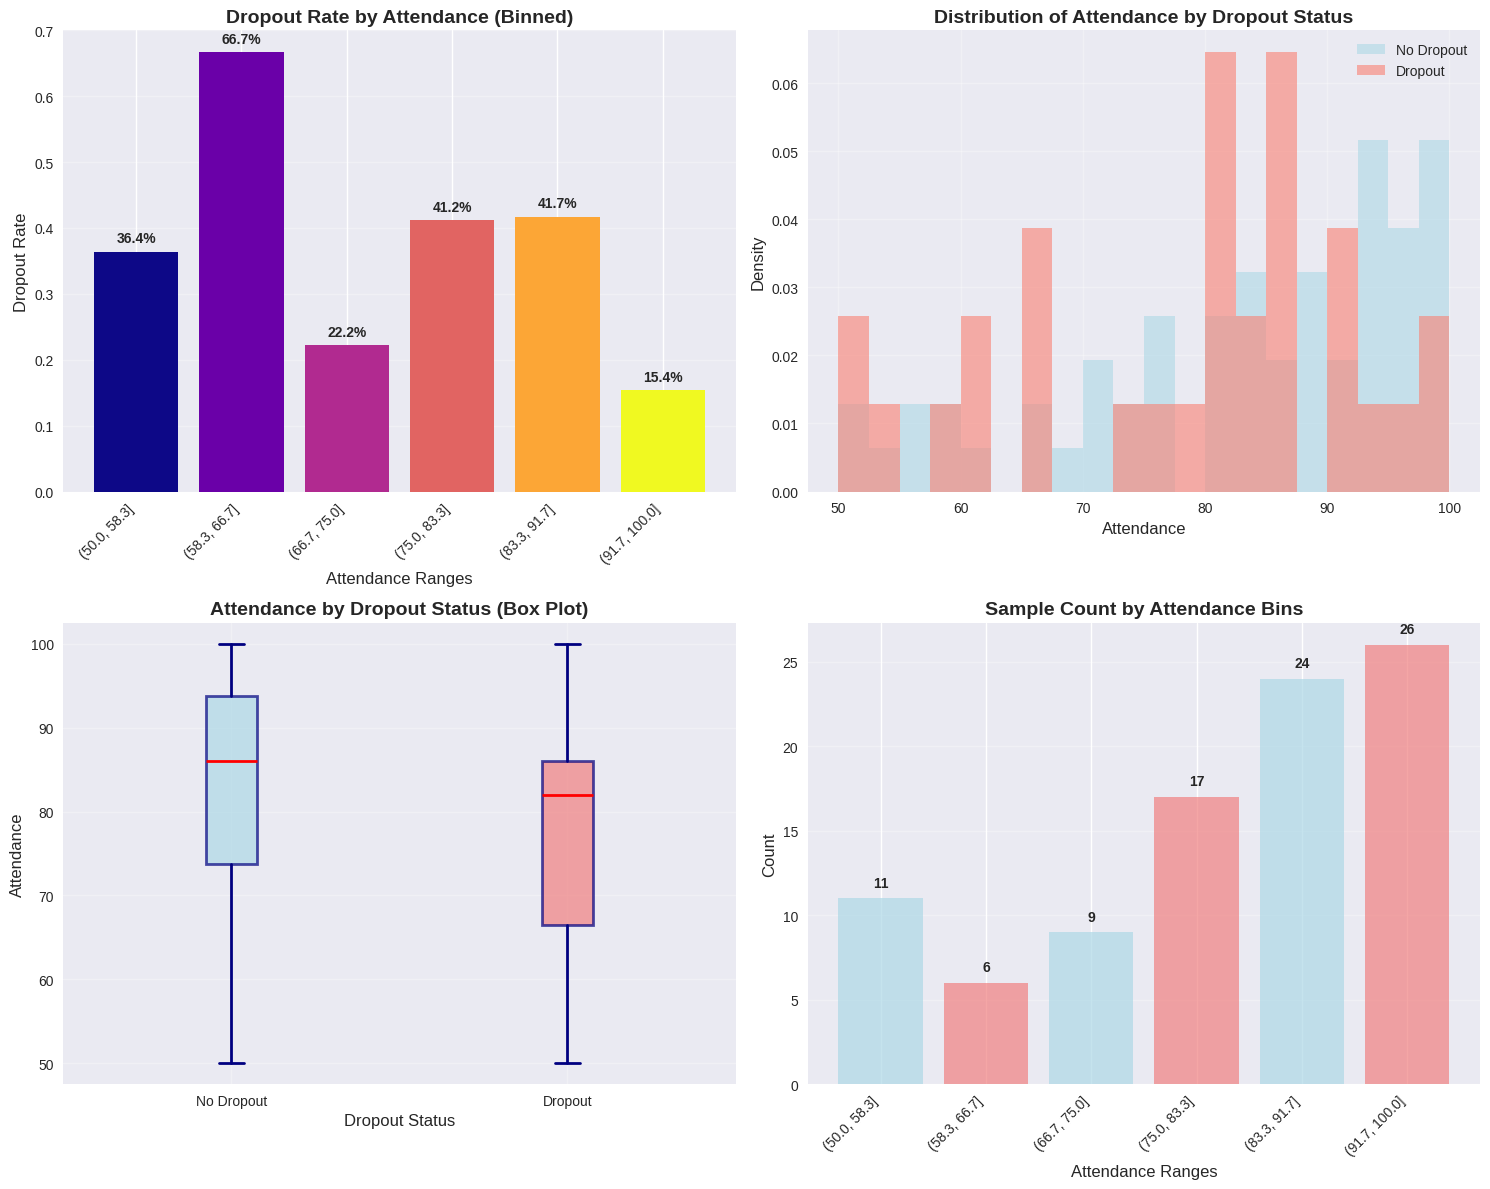

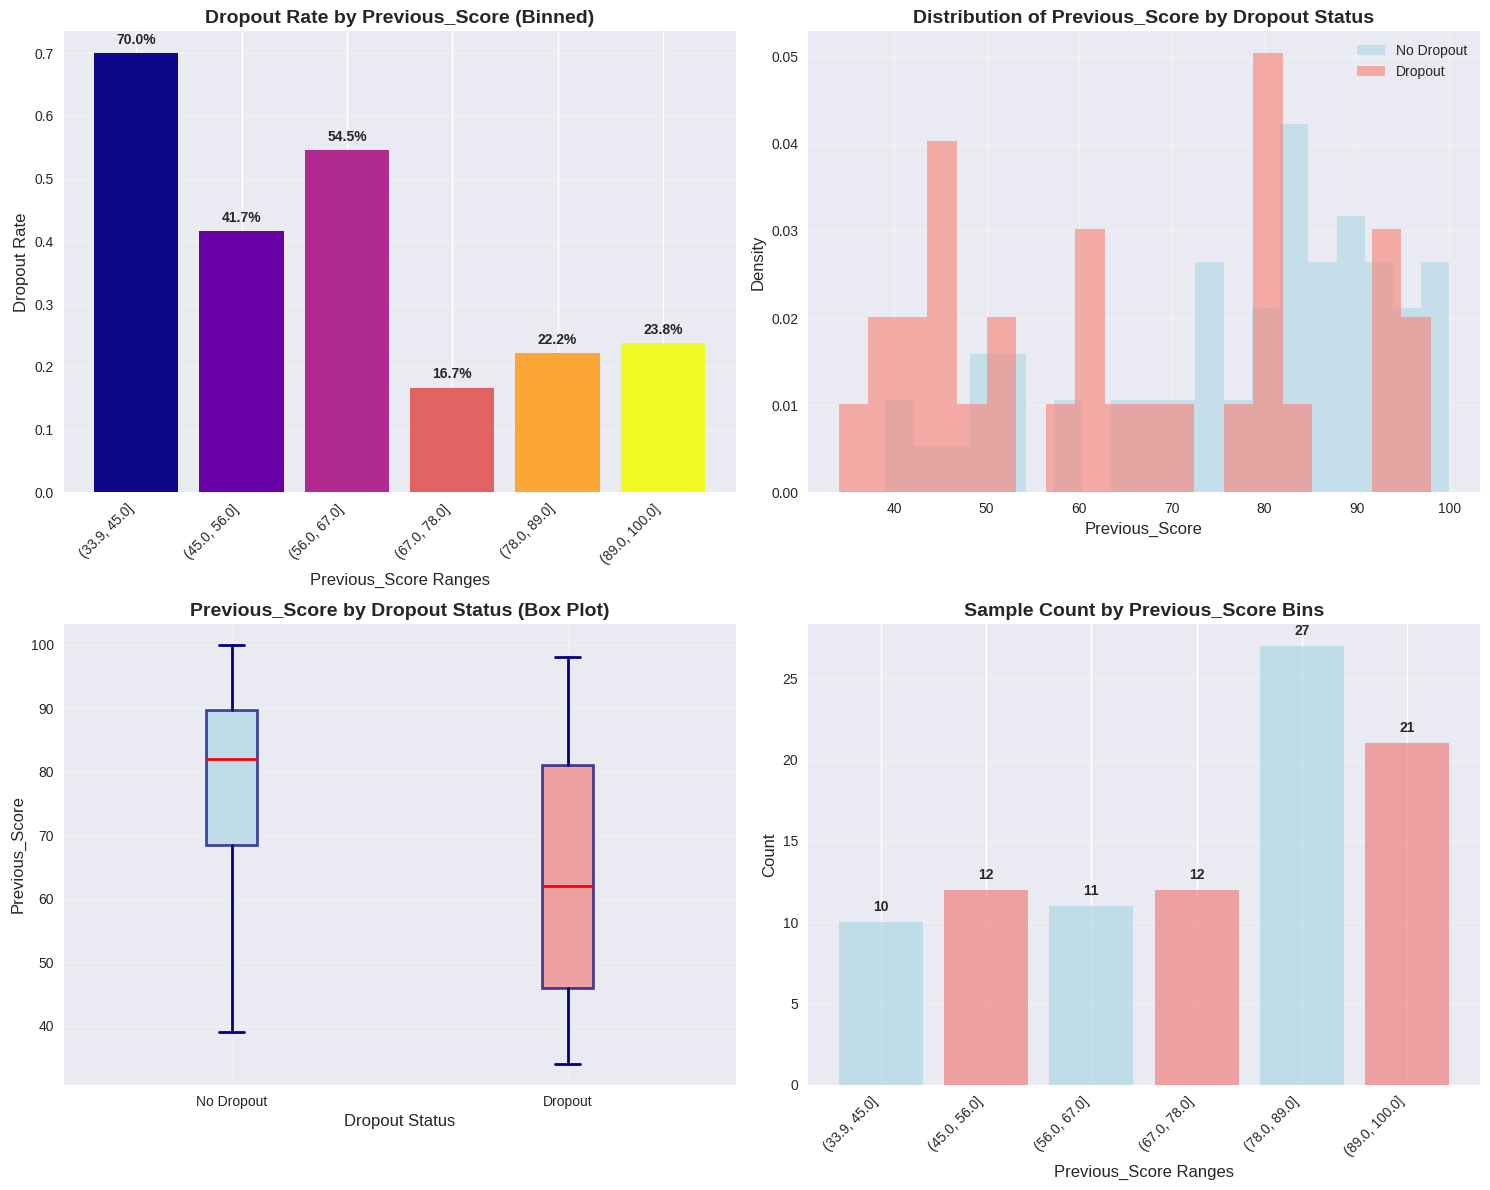

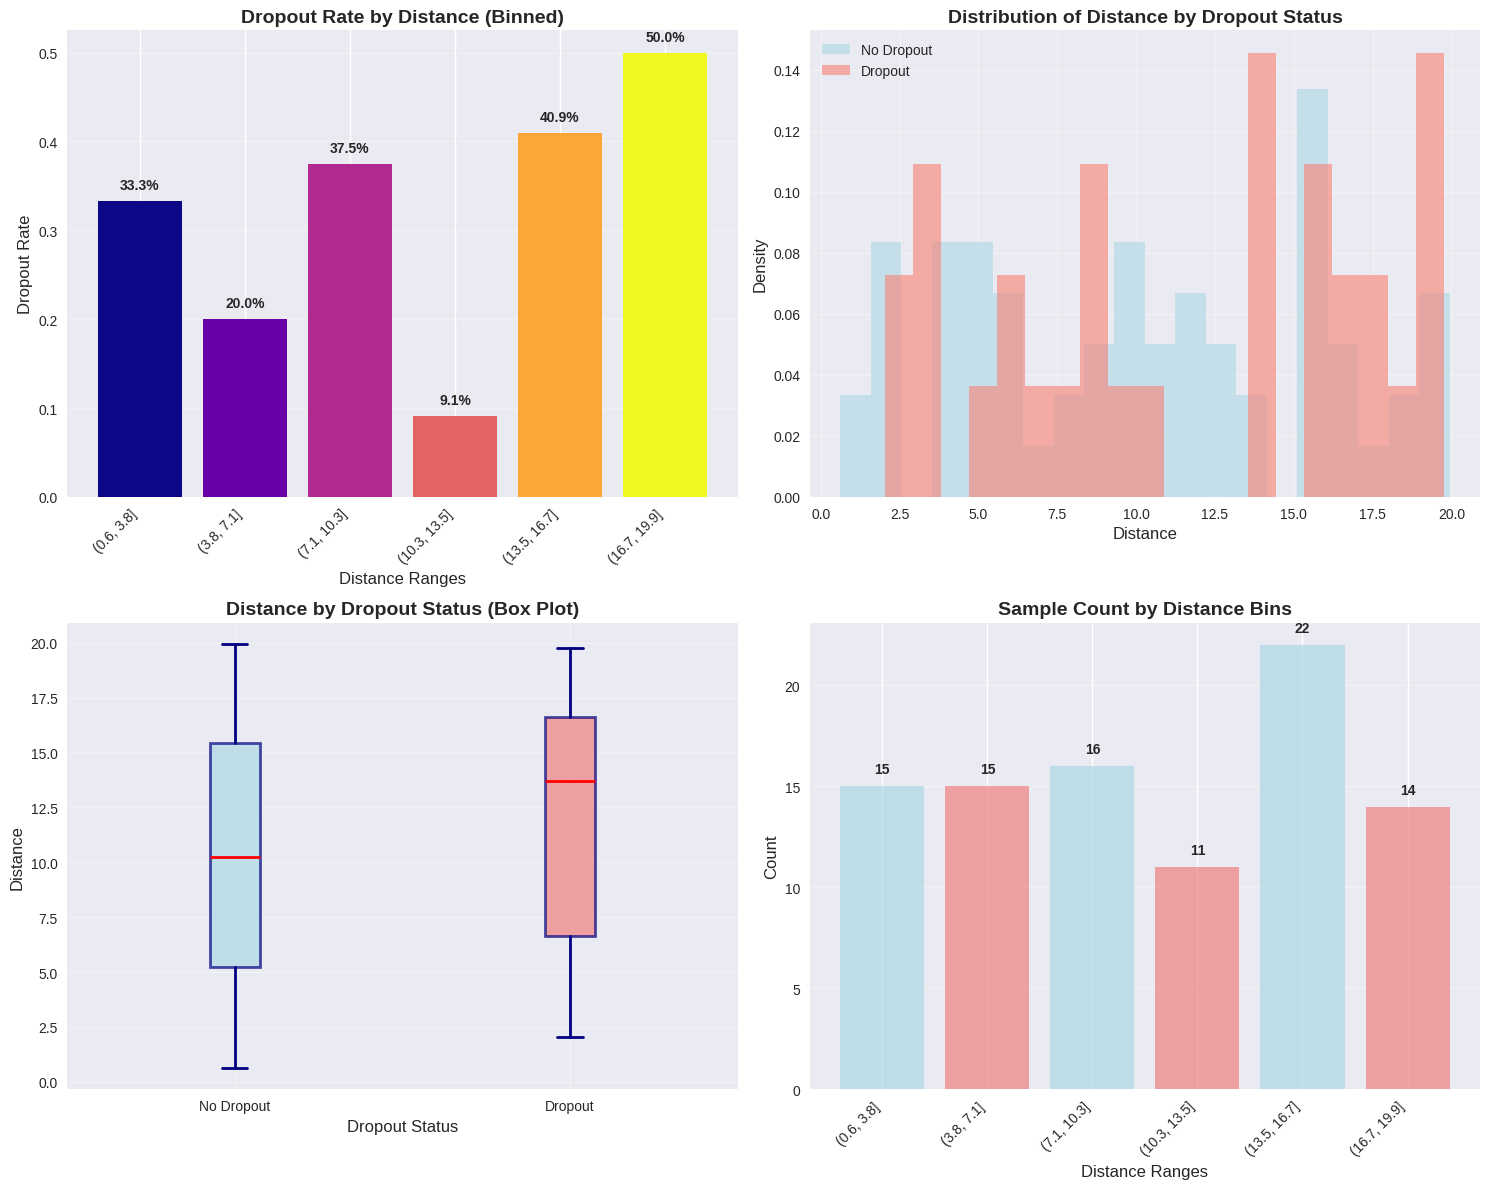

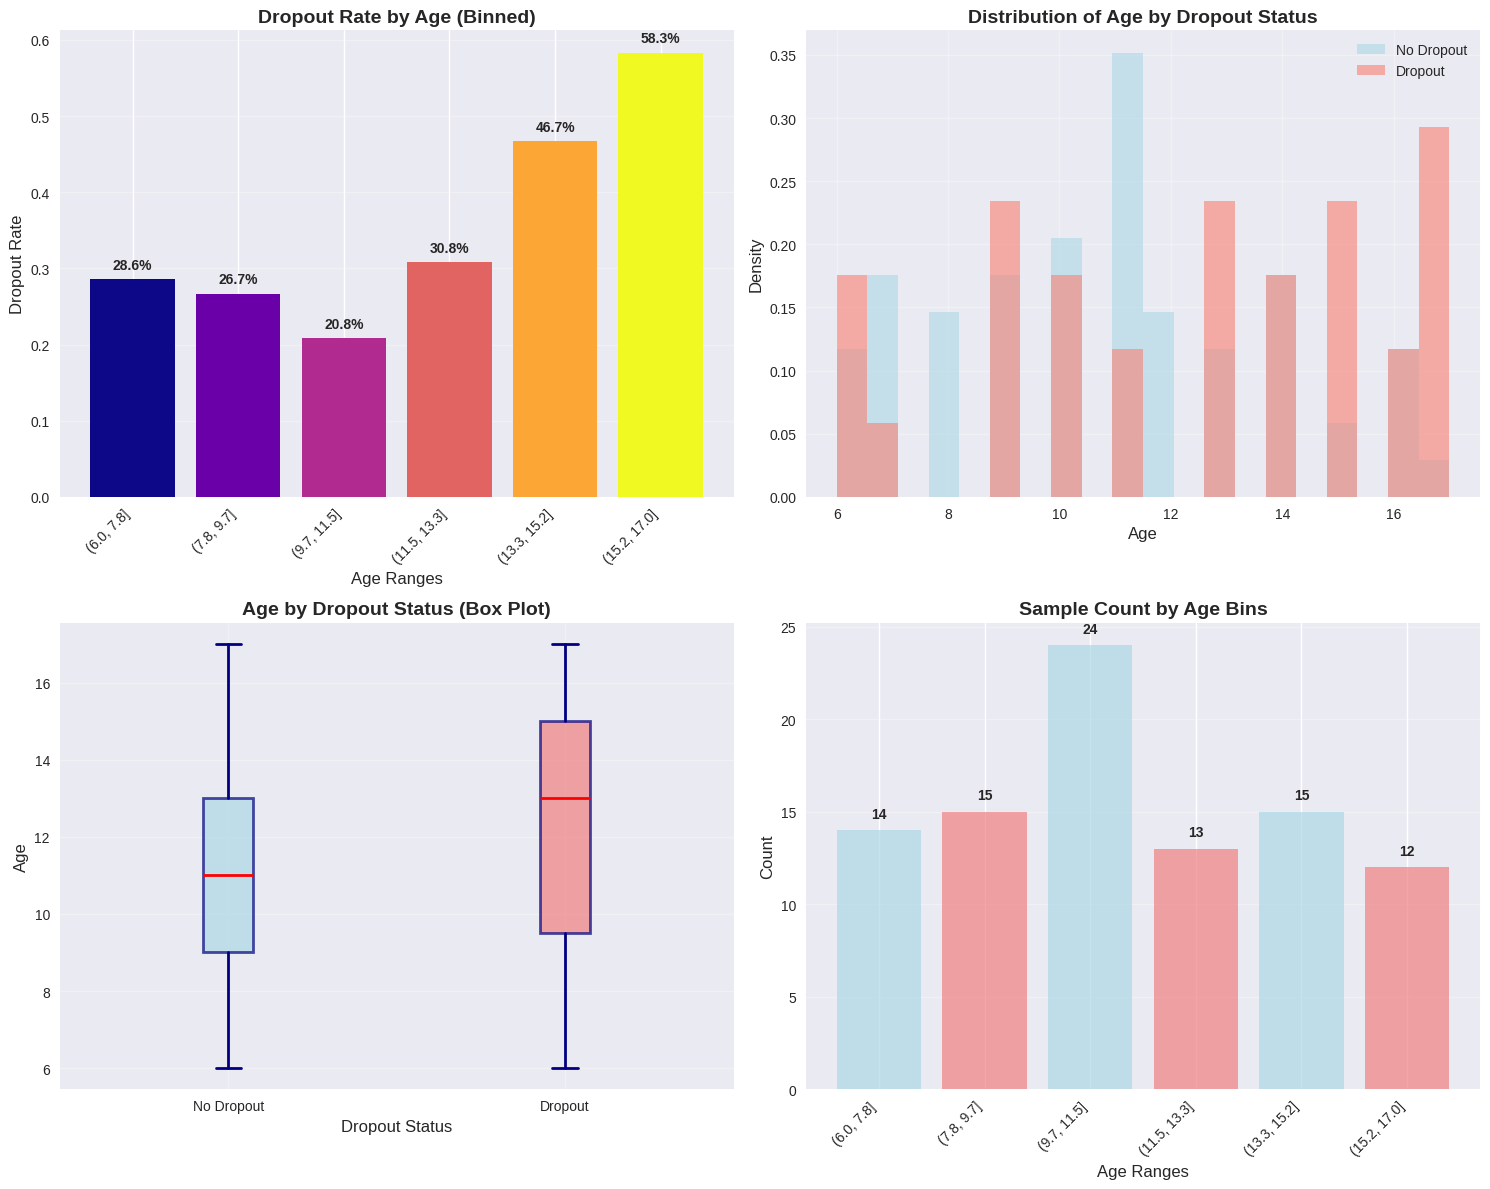

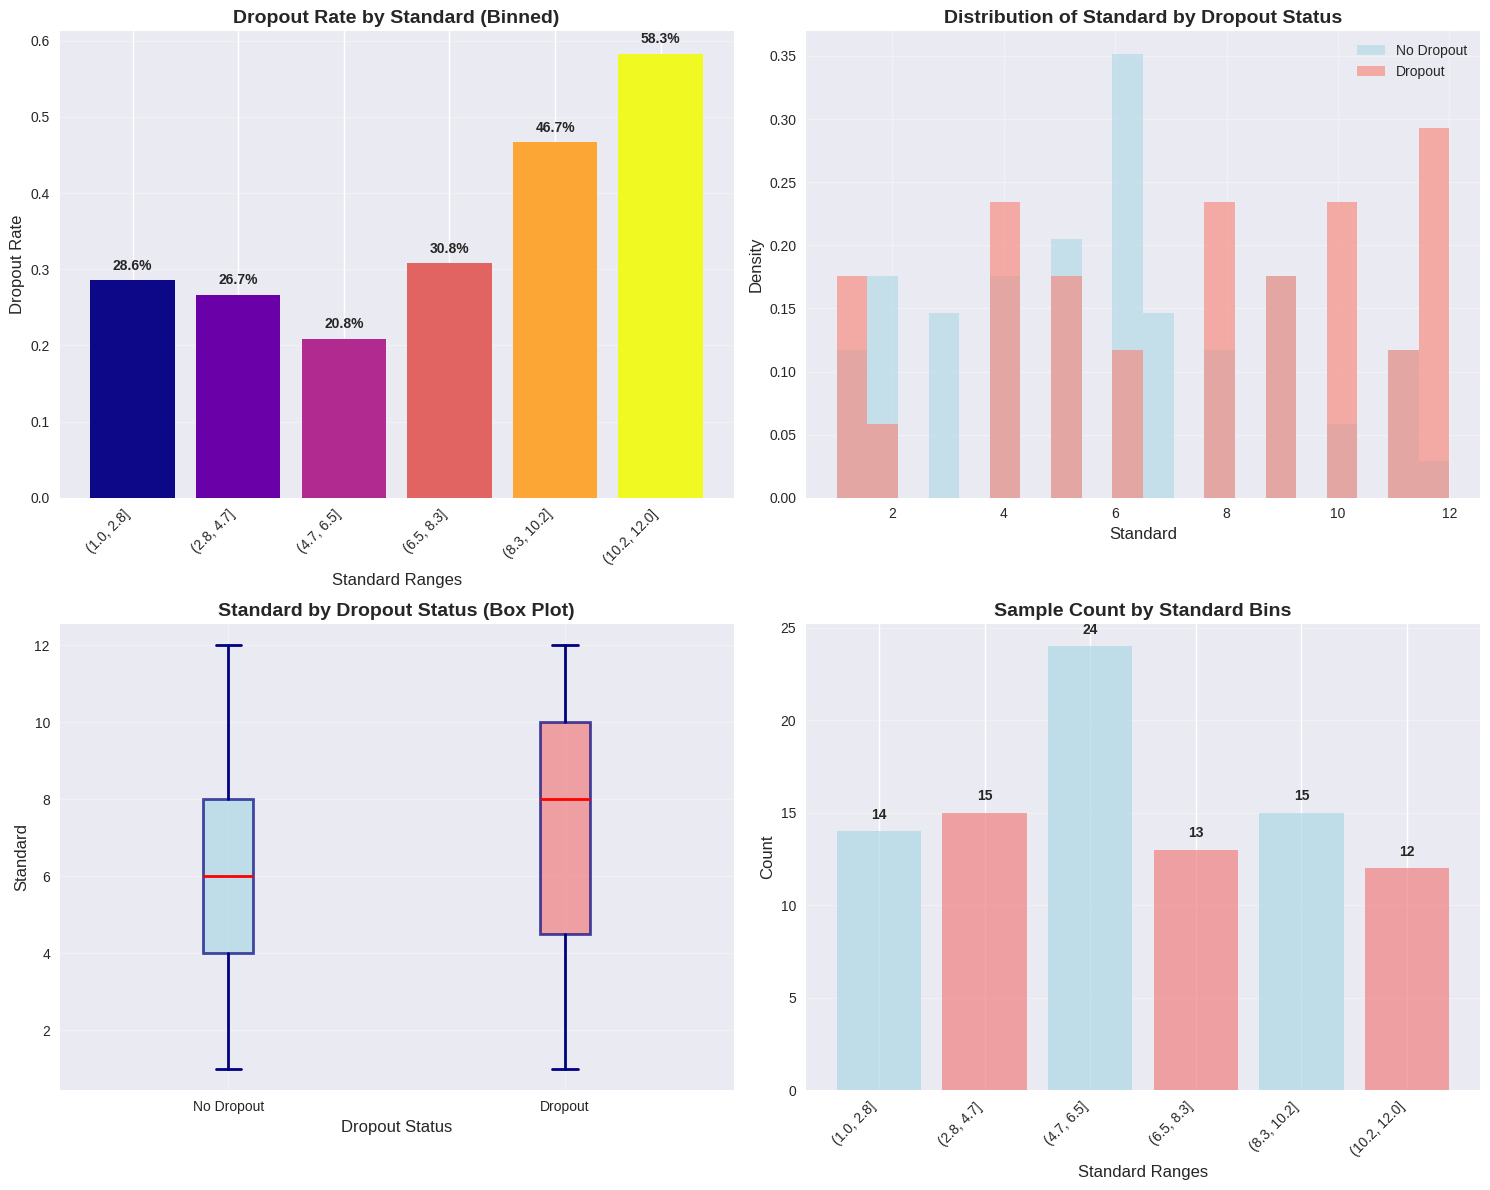

<Figure size 1000x600 with 0 Axes>

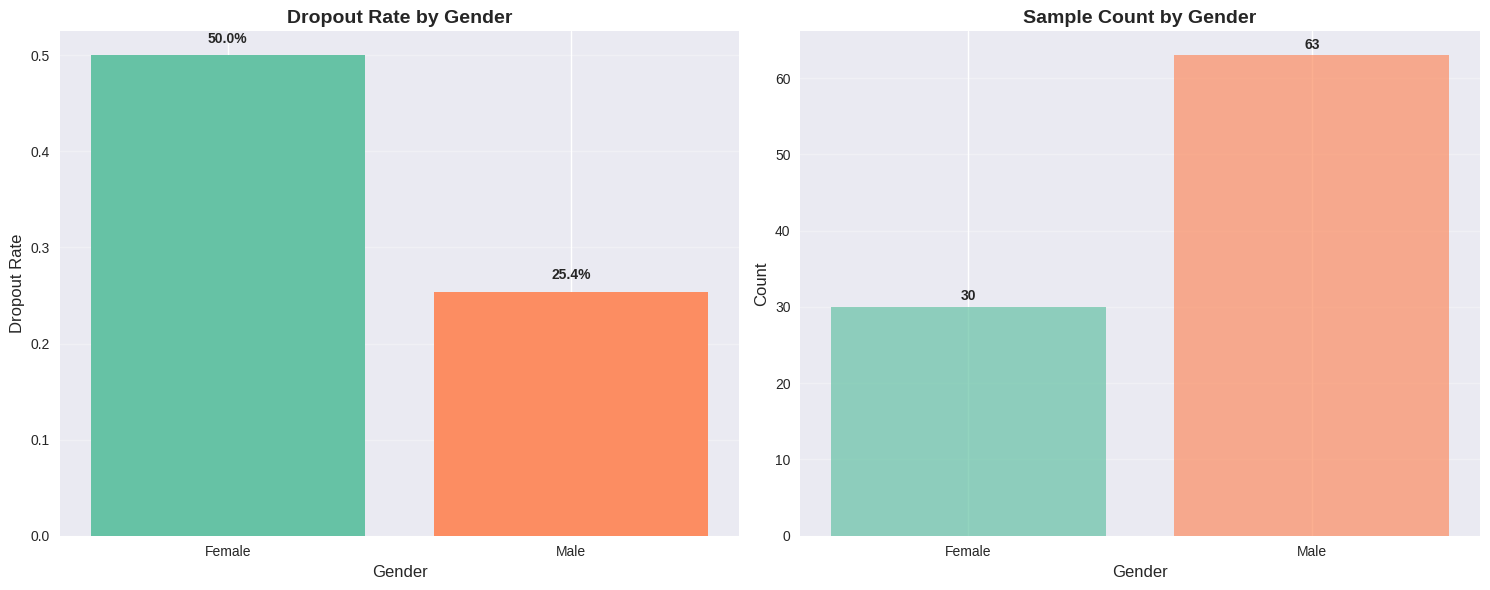

<Figure size 1000x600 with 0 Axes>

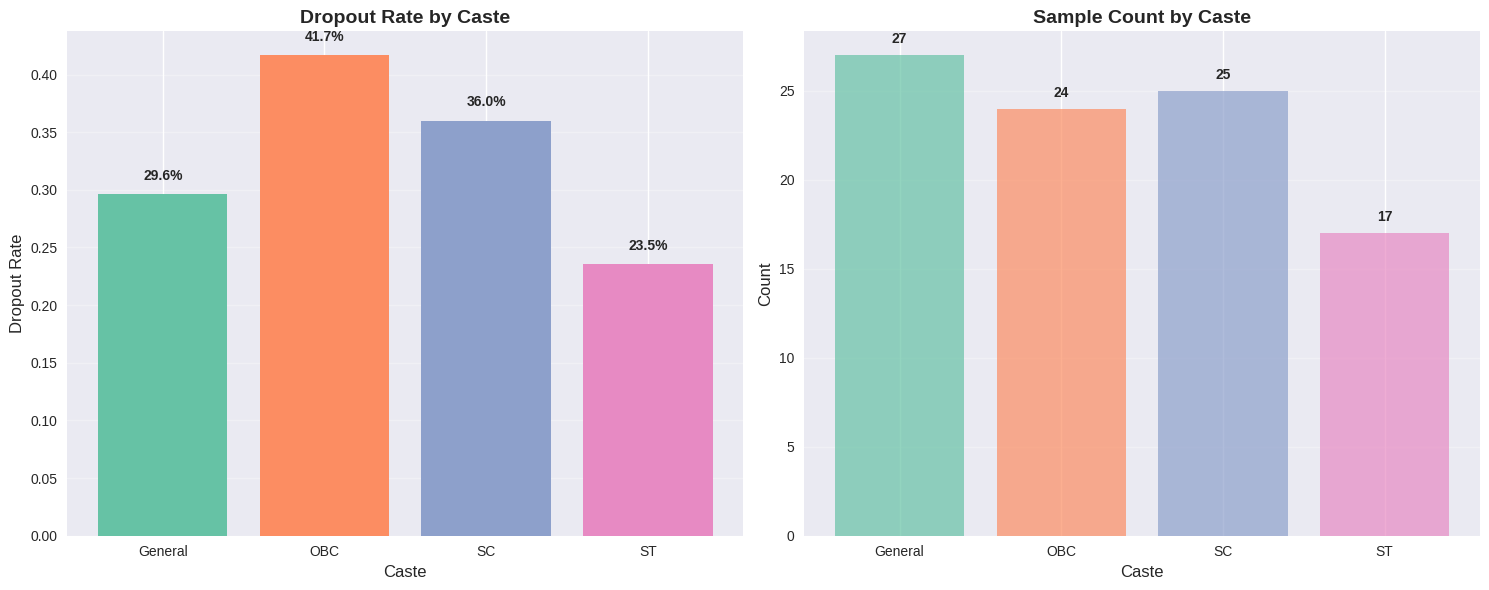

<Figure size 1000x600 with 0 Axes>

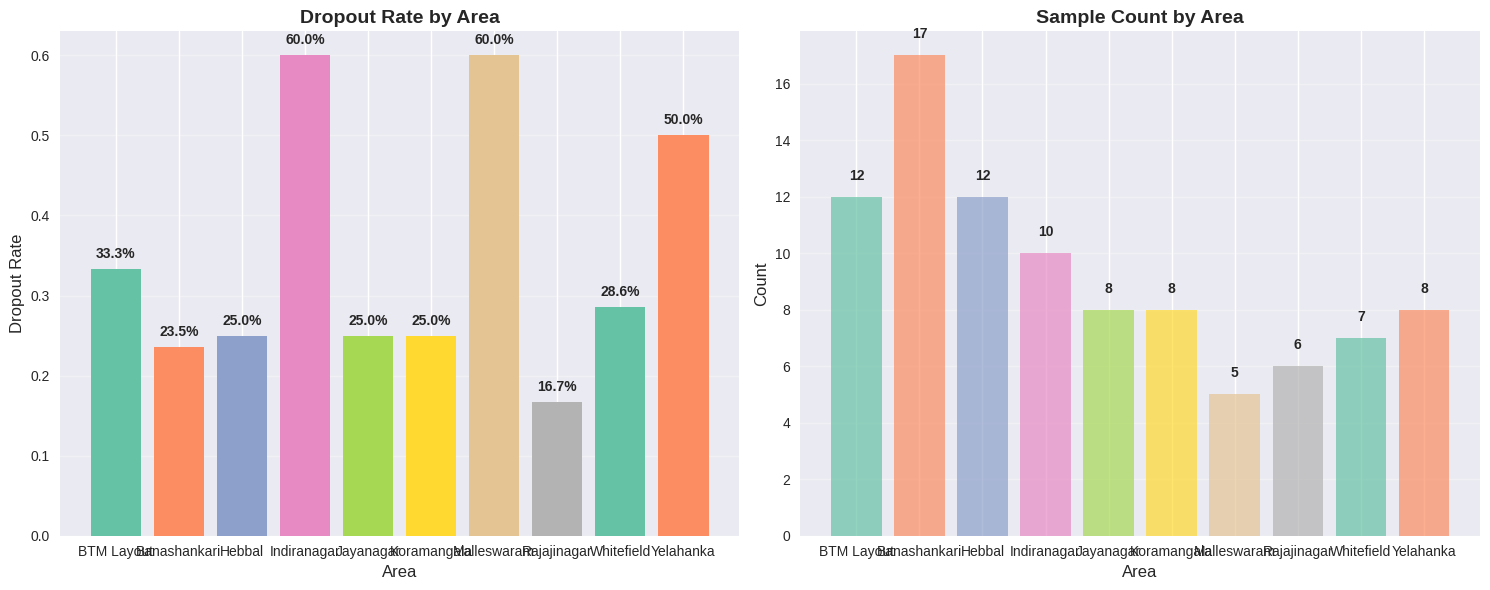

<Figure size 1000x600 with 0 Axes>

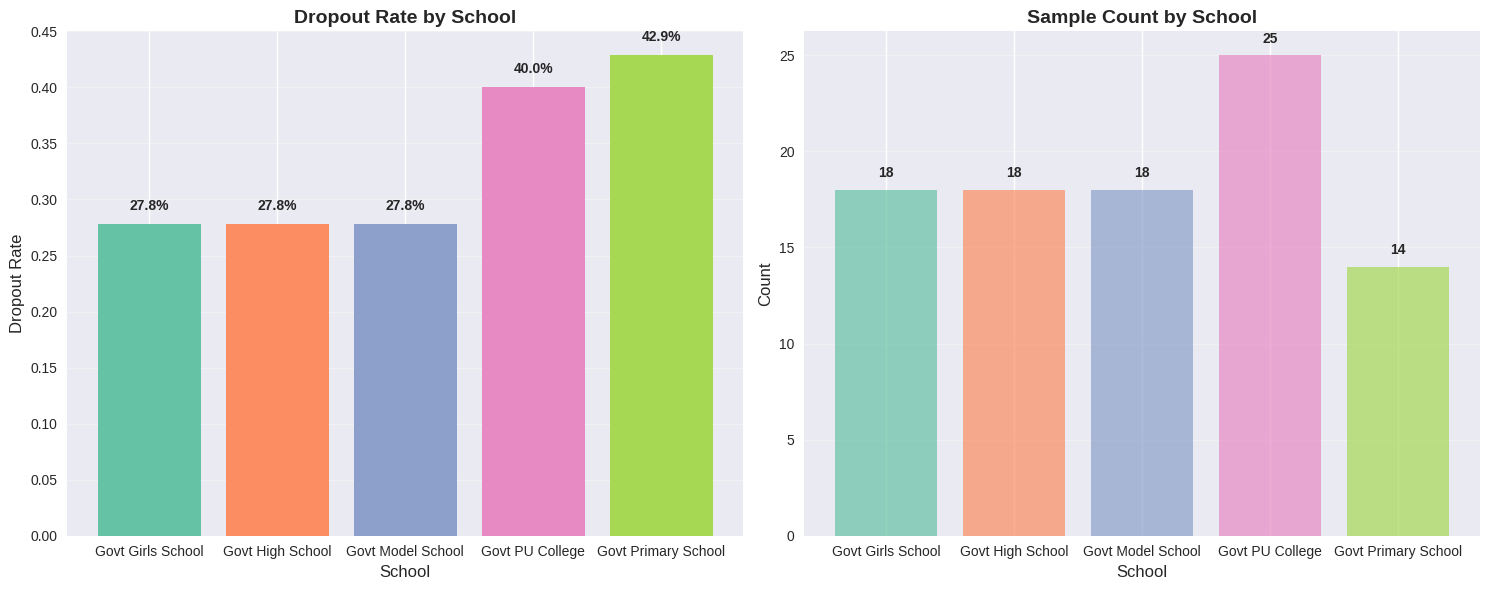

<Figure size 1000x600 with 0 Axes>

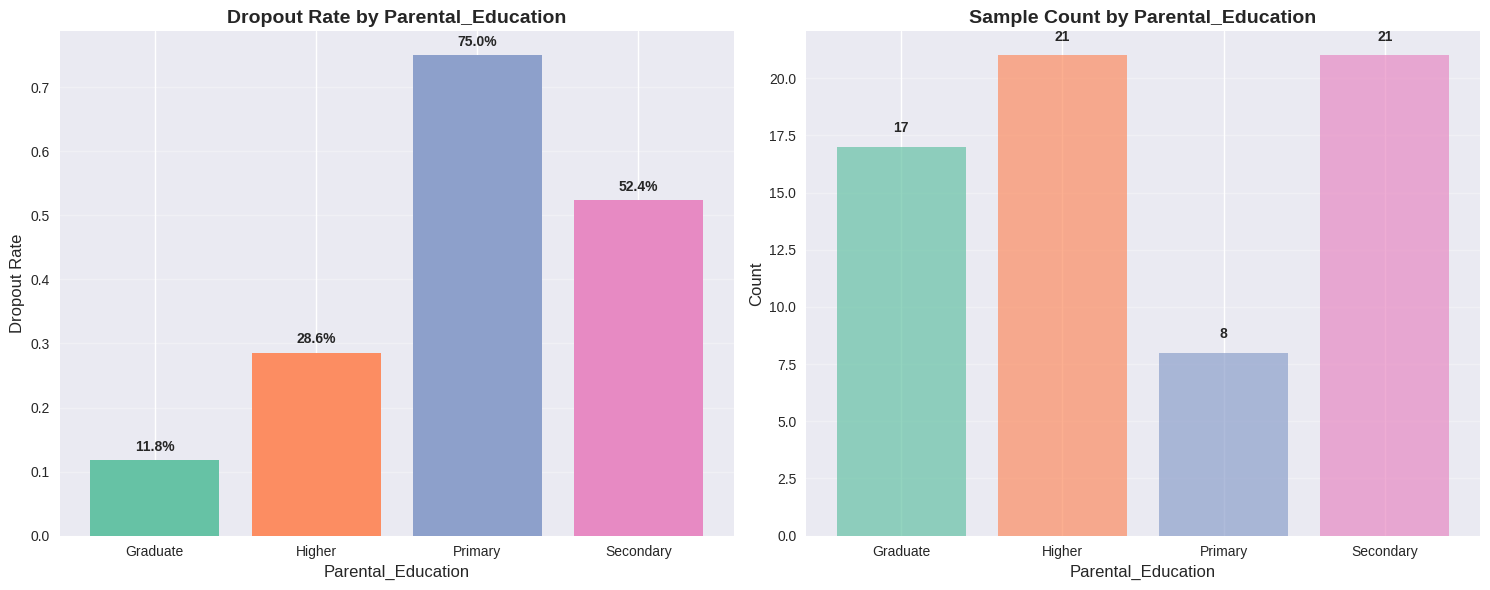

<Figure size 1000x600 with 0 Axes>

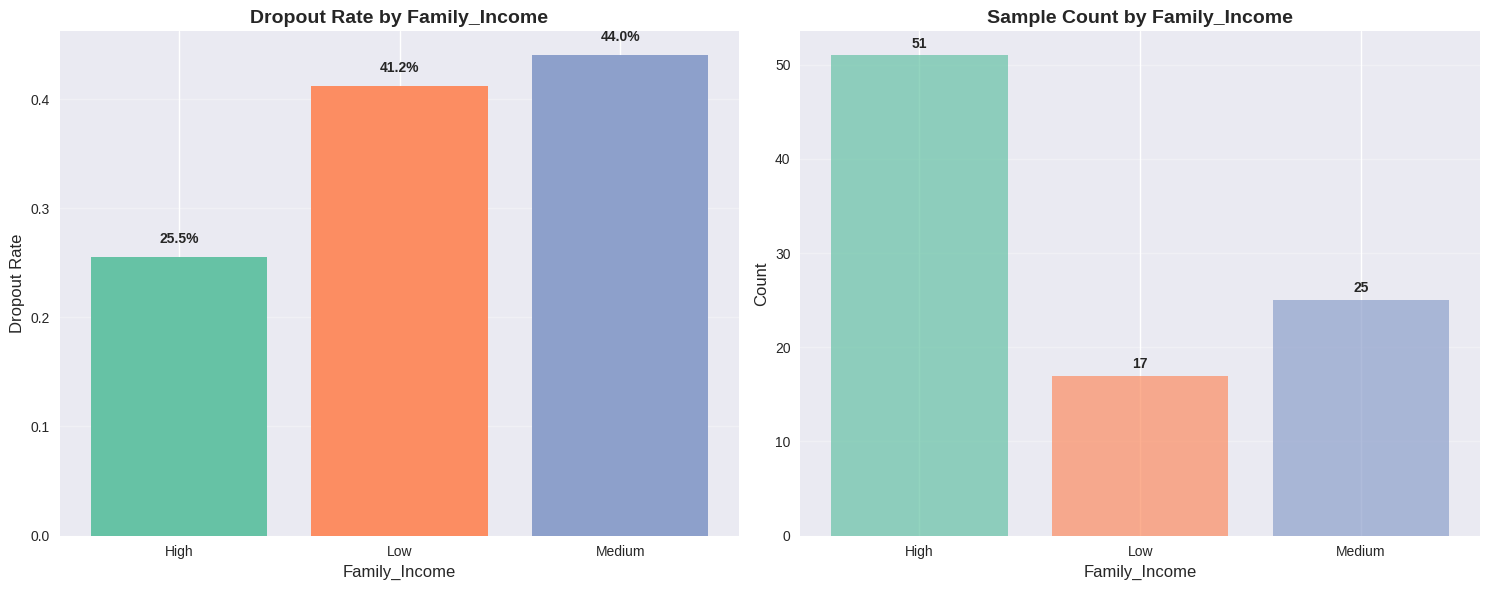

<Figure size 1000x600 with 0 Axes>

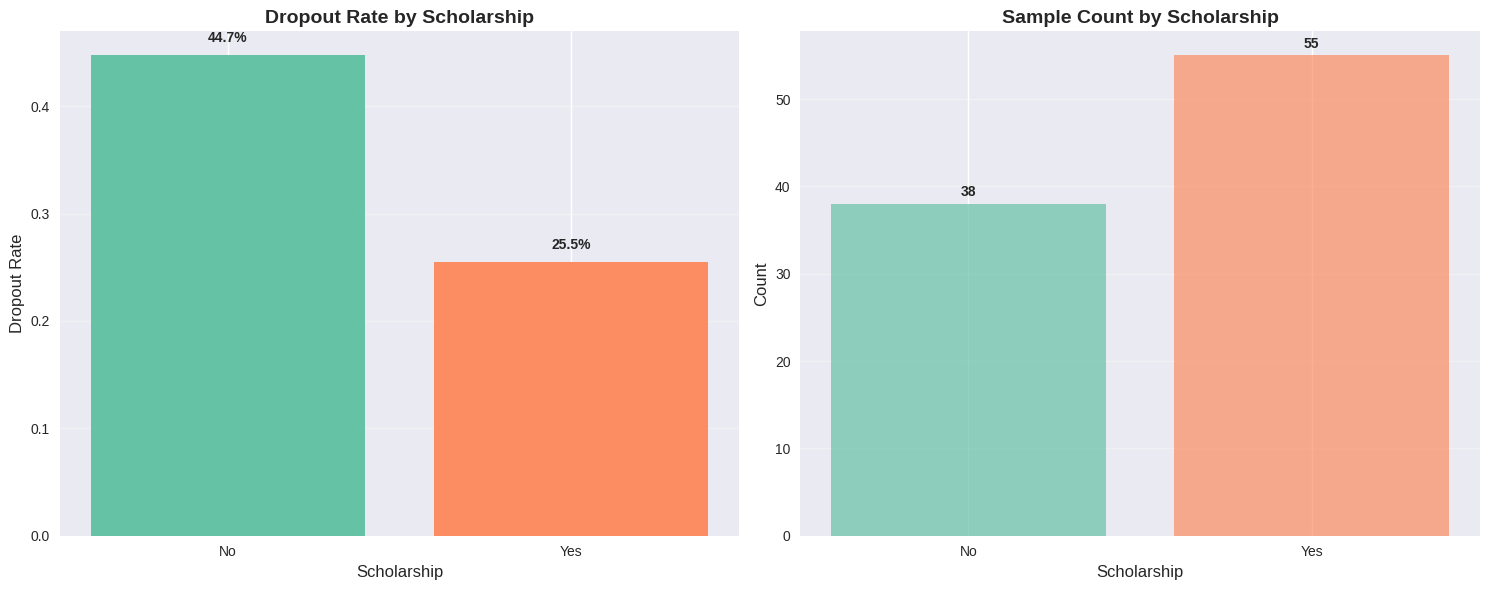

<Figure size 1000x600 with 0 Axes>

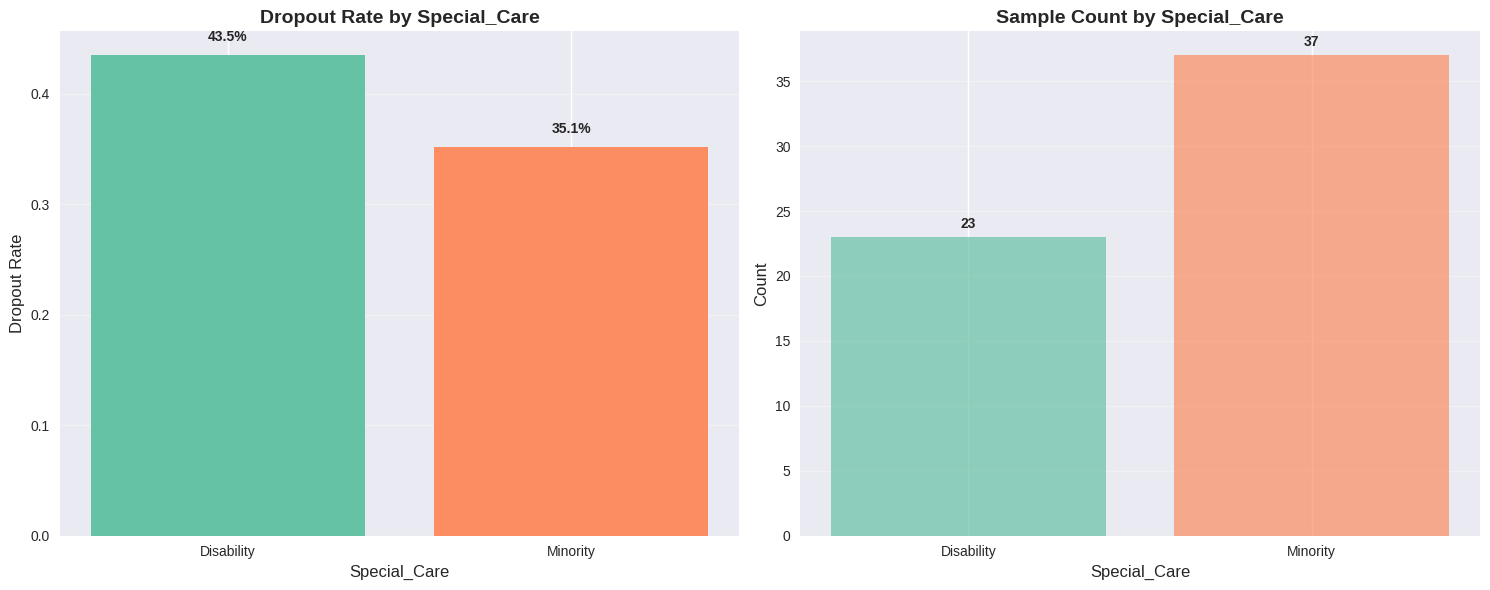

<Figure size 1000x600 with 0 Axes>

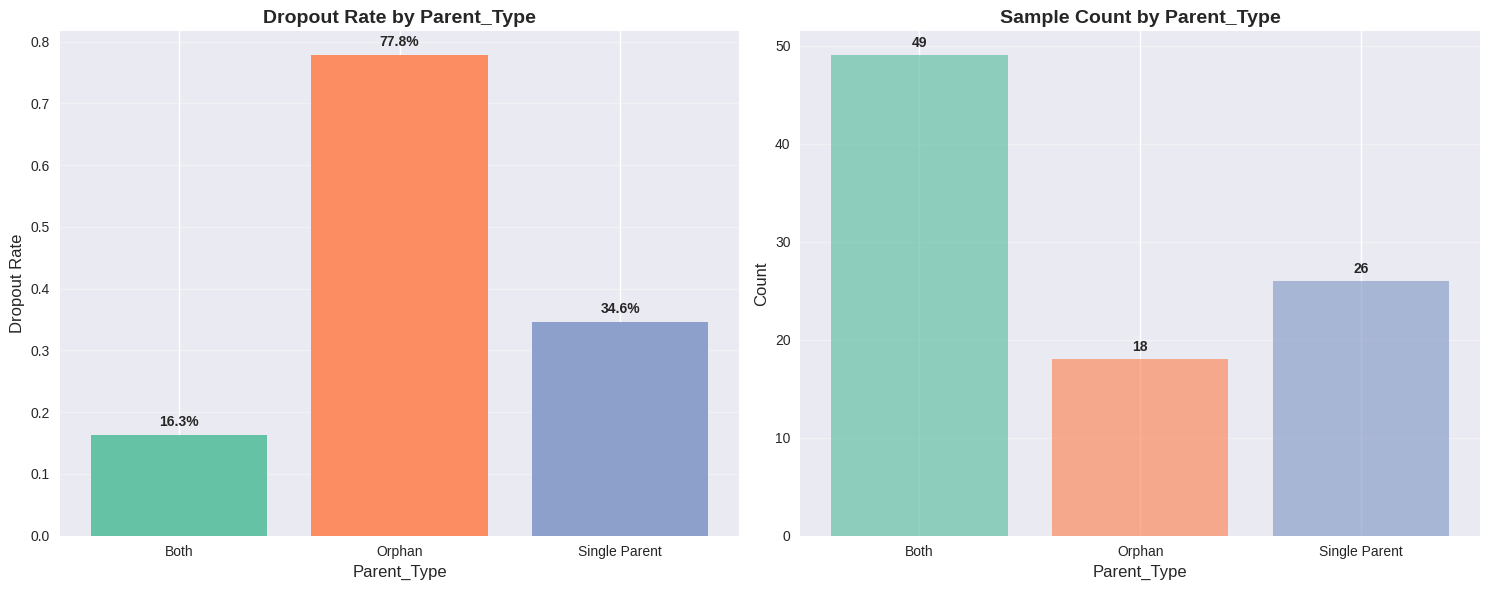

In [ ]:
print("\nGENERATING ENHANCED VISUALIZATIONS\n")

numerical_features = ['Attendance', 'Previous_Score', 'Distance', 'Age', 'Standard']
for feature in numerical_features:
    plot_numerical_enhanced(feature)

categorical_features = ['Gender', 'Caste', 'Area', 'School', 'Parental_Education',
                       'Family_Income', 'Scholarship', 'Special_Care', 'Parent_Type']
for feature in categorical_features:
    plot_categorical_enhanced(feature)

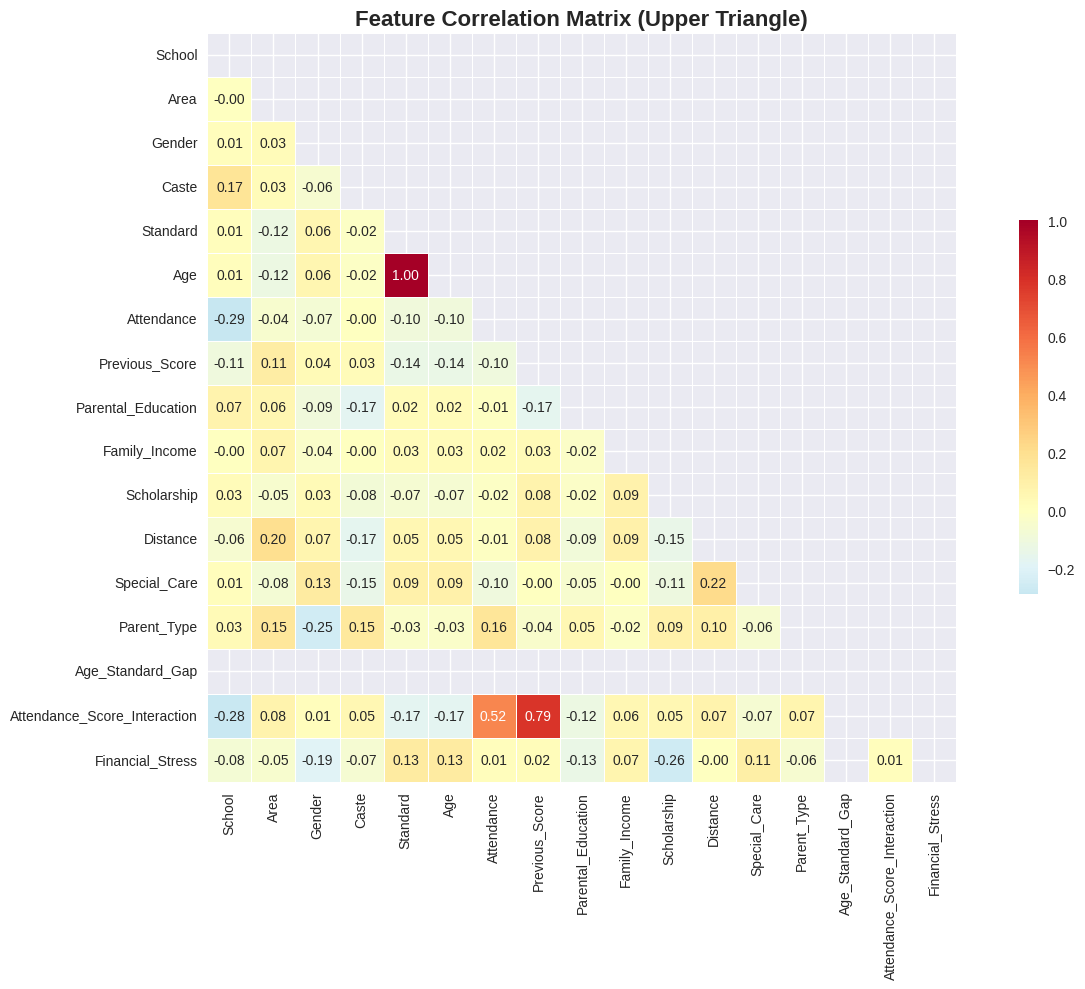

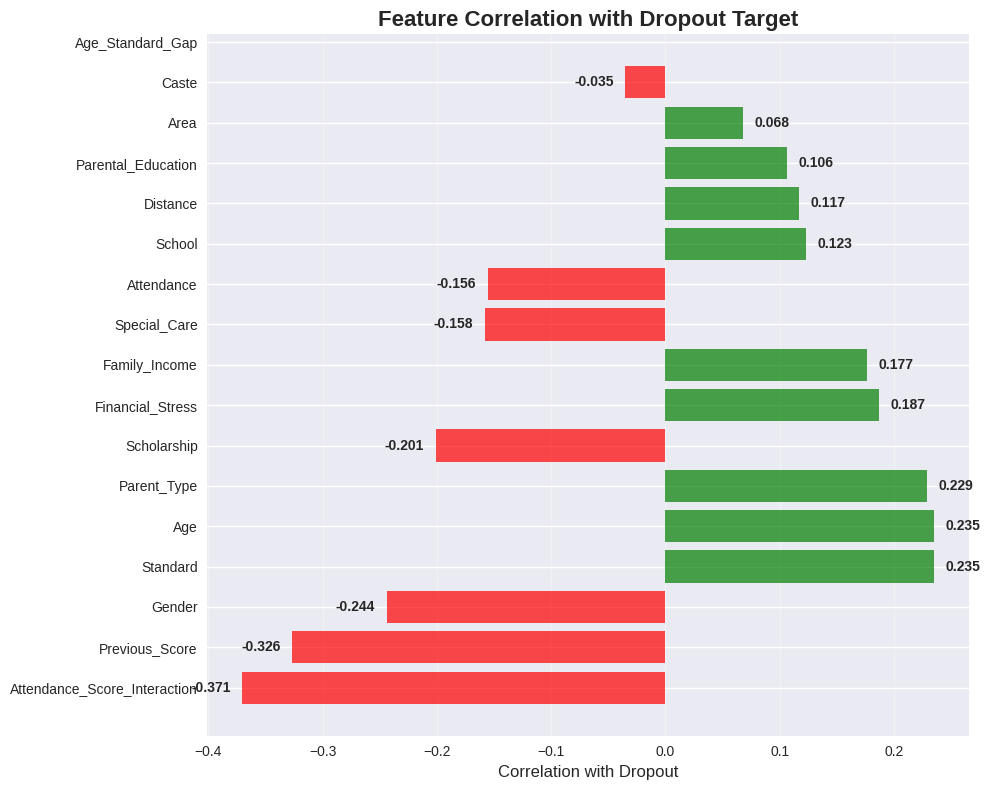

In [ ]:
encoded_data = data.copy()
for col in encoded_data.select_dtypes(include=['object']).columns:
    if col != 'Student_ID':
        encoded_data[col] = LabelEncoder().fit_transform(encoded_data[col])

feature_cols = [col for col in encoded_data.columns if col not in ['Student_ID', 'Dropout']]
feature_corr = encoded_data[feature_cols].corr()

plt.figure(figsize=(14, 10))
mask = np.triu(np.ones_like(feature_corr, dtype=bool))
sns.heatmap(feature_corr, mask=mask, annot=True, cmap='RdYlBu_r', center=0,
            square=True, linewidths=0.5, cbar_kws={"shrink": .5}, fmt='.2f')
plt.title('Feature Correlation Matrix (Upper Triangle)', fontsize=16, fontweight='bold')
plt.tight_layout()
plt.show()

target_corr = encoded_data[feature_cols + ['Dropout']].corr()['Dropout'].drop('Dropout').sort_values(key=abs, ascending=False)

plt.figure(figsize=(10, 8))
colors = ['red' if x < 0 else 'green' for x in target_corr.values]
bars = plt.barh(range(len(target_corr)), target_corr.values, color=colors, alpha=0.7)
plt.yticks(range(len(target_corr)), target_corr.index)
plt.xlabel('Correlation with Dropout', fontsize=12)
plt.title('Feature Correlation with Dropout Target', fontsize=16, fontweight='bold')
plt.grid(axis='x', alpha=0.3)

for i, (bar, corr) in enumerate(zip(bars, target_corr.values)):
    plt.text(bar.get_width() + (0.01 if corr >= 0 else -0.01), bar.get_y() + bar.get_height()/2,
             f'{corr:.3f}', ha='left' if corr >= 0 else 'right', va='center', fontweight='bold')

plt.tight_layout()
plt.show()

STEP 7: MODEL PERFORMANCE

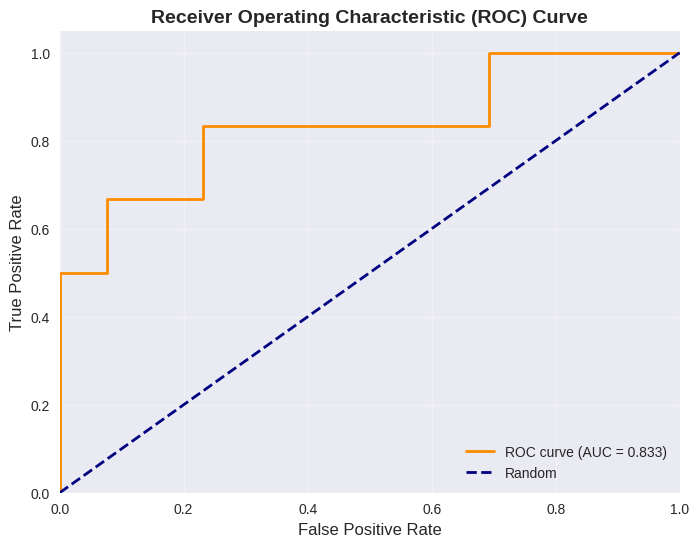

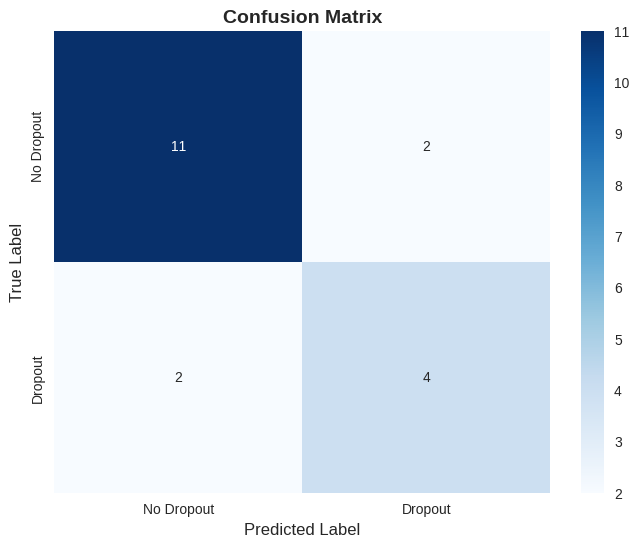

In [ ]:
y_pred_proba = final_model.predict_proba(X_test)[:, 1]
fpr, tpr, _ = roc_curve(y_test, y_pred_proba)
auc_score = roc_auc_score(y_test, y_pred_proba)

plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (AUC = {auc_score:.3f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--', label='Random')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate', fontsize=12)
plt.ylabel('True Positive Rate', fontsize=12)
plt.title('Receiver Operating Characteristic (ROC) Curve', fontsize=14, fontweight='bold')
plt.legend(loc="lower right")
plt.grid(alpha=0.3)
plt.show()

y_pred = final_model.predict(X_test)
cm = confusion_matrix(y_test, y_pred)

plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=['No Dropout', 'Dropout'],
            yticklabels=['No Dropout', 'Dropout'])
plt.title('Confusion Matrix', fontsize=14, fontweight='bold')
plt.ylabel('True Label', fontsize=12)
plt.xlabel('Predicted Label', fontsize=12)
plt.show()

STEP 8: SUMMARY

In [ ]:
print("\n" + "="*50)
print("FINAL MODEL SUMMARY")
print("="*50)
print(f"Final Model: Random Forest")
print(f"Test Accuracy: {accuracy_score(y_test, y_pred):.4f}")
print(f"Test AUC: {auc_score:.4f}")
print("\nClassification Report:")
print(classification_report(y_test, y_pred, target_names=['No Dropout', 'Dropout']))

print(f"\nFinal Dropout Distribution:")
print(data["Dropout"].value_counts(normalize=True))

print("\nTop 5 Most Important Features:")
top_features = feature_importance.tail(5)
for idx, row in top_features.iterrows():
    print(f"{row['feature']}: {row['importance']:.4f}")


FINAL MODEL SUMMARY
Final Model: Random Forest
Test Accuracy: 0.7895
Test AUC: 0.8333

Classification Report:
              precision    recall  f1-score   support

  No Dropout       0.85      0.85      0.85        13
     Dropout       0.67      0.67      0.67         6

    accuracy                           0.79        19
   macro avg       0.76      0.76      0.76        19
weighted avg       0.79      0.79      0.79        19


Final Dropout Distribution:
Dropout
0    0.666667
1    0.333333
Name: proportion, dtype: float64

Top 5 Most Important Features:
Age: 0.0793
Parent_Type: 0.0803
Attendance: 0.0967
Previous_Score: 0.1507
Attendance_Score_Interaction: 0.1823


TESTING CODE

In [ ]:
# Check what values exist in your training data
print("Valid values for categorical columns:")
print("="*50)

for col in categorical_columns:
    print(f"\n{col}:")
    valid_values = label_encoders[col].classes_
    print(f"  {list(valid_values)}")

Valid values for categorical columns:

School:
  ['Govt Girls School', 'Govt High School', 'Govt Model School', 'Govt PU College', 'Govt Primary School']

Area:
  ['BTM Layout', 'Banashankari', 'Hebbal', 'Indiranagar', 'Jayanagar', 'Koramangala', 'Malleswaram', 'Rajajinagar', 'Whitefield', 'Yelahanka']

Gender:
  ['Female', 'Male']

Caste:
  ['General', 'OBC', 'SC', 'ST']

Parental_Education:
  ['Graduate', 'Higher', 'Primary', 'Secondary', nan]

Family_Income:
  ['High', 'Low', 'Medium']

Scholarship:
  ['No', 'Yes']

Special_Care:
  ['Disability', 'Minority', nan]

Parent_Type:
  ['Both', 'Orphan', 'Single Parent']


In [ ]:
"""
FINAL FIXED PREDICTION FUNCTION
"""

def predict_dropout(student_data):
    """
    Predict dropout probability for a student
    student_data: dict with feature names as keys
    """

    # Create DataFrame with features in the EXACT order used during training
    input_df = pd.DataFrame([student_data])

    # Reorder columns to match the training feature order
    input_df = input_df[feature_columns]

    # Apply label encoding to categorical columns
    for col in categorical_columns:
        if col in input_df.columns:
            le = label_encoders[col]

            # Check if NaN exists in training classes
            has_nan_in_training = any(pd.isna(c) if isinstance(c, float) else c == 'nan' for c in le.classes_)

            if has_nan_in_training:
                # If training had NaN, keep NaN as is (it's already encoded)
                pass
            else:
                # If training didn't have NaN, fill with most common value
                if input_df[col].isna().any():
                    # Use the first class as default (or you could use mode)
                    input_df[col] = input_df[col].fillna(le.classes_[0])

            input_df[col] = le.transform(input_df[col])

    # Apply standard scaling to numerical columns
    input_df[numerical_columns] = scaler.transform(input_df[numerical_columns])

    # Make prediction
    prediction = final_model.predict(input_df)[0]
    probability = final_model.predict_proba(input_df)[0]

    return {
        'prediction': int(prediction),
        'prediction_label': 'Dropout' if prediction == 1 else 'No Dropout',
        'dropout_probability': float(probability[1]),
        'no_dropout_probability': float(probability[0])
    }

# Test all three cases again
print("\n" + "="*50)
print("FINAL TESTING")
print("="*50)

test_cases = [
    {
        'name': 'High Risk Student',
        'data': {
            'Age': 16, 'Gender': 'Male', 'Standard': 9, 'Caste': 'SC',
            'Area': 'Hebbal', 'School': 'Govt Primary School',
            'Attendance': 45.0, 'Previous_Score': 35.0,
            'Parental_Education': 'Primary', 'Family_Income': 'Low',
            'Distance': 18.0, 'Scholarship': 'No',
            'Special_Care': 'Minority', 'Parent_Type': 'Single Parent',
            'Age_Standard_Gap': 2, 'Attendance_Score_Interaction': 15.75,
            'Financial_Stress': 1
        }
    },
    {
        'name': 'Low Risk Student',
        'data': {
            'Age': 14, 'Gender': 'Female', 'Standard': 8, 'Caste': 'General',
            'Area': 'Rajajinagar', 'School': 'Govt High School',
            'Attendance': 95.0, 'Previous_Score': 85.0,
            'Parental_Education': 'Graduate', 'Family_Income': 'High',
            'Distance': 3.0, 'Scholarship': 'Yes',
            'Special_Care': 'Disability', 'Parent_Type': 'Both',
            'Age_Standard_Gap': 1, 'Attendance_Score_Interaction': 80.75,
            'Financial_Stress': 0
        }
    },
    {
        'name': 'Medium Risk (with defaults for missing)',
        'data': {
            'Age': 15, 'Gender': 'Male', 'Standard': 10, 'Caste': 'OBC',
            'Area': 'Koramangala', 'School': 'Govt Model School',
            'Attendance': 70.0, 'Previous_Score': 55.0,
            'Parental_Education': 'Secondary',  # Changed from NaN
            'Family_Income': 'Medium', 'Distance': 8.0,
            'Scholarship': 'No', 'Special_Care': 'Minority',  # Changed from NaN
            'Parent_Type': 'Both', 'Age_Standard_Gap': 0,
            'Attendance_Score_Interaction': 38.5, 'Financial_Stress': 0
        }
    }
]

for test in test_cases:
    try:
        result = predict_dropout(test['data'])
        print(f"\n✅ {test['name']}:")
        print(f"   Prediction: {result['prediction_label']}")
        print(f"   Dropout Probability: {result['dropout_probability']:.2%}")
    except Exception as e:
        print(f"\n❌ {test['name']}: {e}")

print("\n" + "="*50)


FINAL TESTING

✅ High Risk Student:
   Prediction: Dropout
   Dropout Probability: 85.77%

✅ Low Risk Student:
   Prediction: No Dropout
   Dropout Probability: 20.71%

✅ Medium Risk (with defaults for missing):
   Prediction: Dropout
   Dropout Probability: 63.43%



In [ ]:
"""
# @title
"""
#STEP 9: EXPORT MODEL AND ALL COMPONENTS FOR DEPLOYMENT
"""

import joblib
from google.colab import files
import json

print("\n" + "="*50)
print("EXPORTING MODEL FOR DEPLOYMENT")
print("="*50)

# 1. Export the trained Random Forest model
joblib.dump(final_model, 'random_forest_model.pkl')
print("✅ Model exported: random_forest_model.pkl")

# 2. Export the StandardScaler
joblib.dump(scaler, 'scaler.pkl')
print("✅ Scaler exported: scaler.pkl")

# 3. Export Label Encoders
joblib.dump(label_encoders, 'label_encoders.pkl')
print("✅ Label encoders exported: label_encoders.pkl")

# 4. Export feature names and metadata
model_metadata = {
    'feature_columns': feature_columns,
    'categorical_columns': list(categorical_columns),
    'numerical_columns': list(numerical_columns),
    'target_classes': [int(c) for c in final_model.classes_],
    'n_features': len(feature_columns),
    'valid_values': {
        'Gender': list(label_encoders['Gender'].classes_),
        'Caste': list(label_encoders['Caste'].classes_),
        'Area': list(label_encoders['Area'].classes_),
        'School': list(label_encoders['School'].classes_),
        'Parental_Education': [str(c) if not pd.isna(c) else 'Unknown' for c in label_encoders['Parental_Education'].classes_],
        'Family_Income': list(label_encoders['Family_Income'].classes_),
        'Scholarship': list(label_encoders['Scholarship'].classes_),
        'Special_Care': [str(c) if not pd.isna(c) else 'Unknown' for c in label_encoders['Special_Care'].classes_],
        'Parent_Type': list(label_encoders['Parent_Type'].classes_)
    }
}

with open('model_metadata.json', 'w') as f:
    json.dump(model_metadata, f, indent=4)
print("✅ Model metadata exported: model_metadata.json")

# 5. Export model performance metrics
metrics = {
    'model_name': 'Random Forest',
    'test_accuracy': float(accuracy_score(y_test, y_pred)),
    'test_auc': float(auc_score),
    'confusion_matrix': cm.tolist(),
    'classification_report': classification_report(y_test, y_pred,
                                                   target_names=['No Dropout', 'Dropout'],
                                                   output_dict=True)
}

with open('model_metrics.json', 'w') as f:
    json.dump(metrics, f, indent=4)
print("✅ Model metrics exported: model_metrics.json")

# 6. Export feature importance for visualization
feature_importance_export = feature_importance.copy()
feature_importance_export.to_csv('feature_importance.csv', index=False)
print("✅ Feature importance exported: feature_importance.csv")

# 7. Export sample test data (first 10 rows)
sample_test = X_test.head(10).copy()
sample_test['Actual_Dropout'] = y_test.head(10).values

# Reverse the encoding for better readability
sample_test_readable = sample_test.copy()
for col in categorical_columns:
    if col in sample_test_readable.columns:
        # Denormalize the numerical values first
        sample_test_readable[col] = scaler.inverse_transform(
            sample_test_readable[numerical_columns]
        )[:, list(numerical_columns).index(col)] if col in numerical_columns else sample_test_readable[col]

sample_test.to_csv('sample_test_data.csv', index=False)
print("✅ Sample test data exported: sample_test_data.csv")

# 8. Create a requirements.txt file
requirements = """#scikit-learn==1.3.0
#pandas==2.0.3
#numpy==1.24.3
#joblib==1.3.2
#flask==3.0.0
#flask-cors==4.0.0
"""

with open('requirements.txt', 'w') as f:
    f.write(requirements)
print("✅ Requirements exported: requirements.txt")

# 9. Download all files
print("\n📥 Downloading files...")
files.download('random_forest_model.pkl')
files.download('scaler.pkl')
files.download('label_encoders.pkl')
files.download('model_metadata.json')
files.download('model_metrics.json')
files.download('feature_importance.csv')
files.download('sample_test_data.csv')
files.download('requirements.txt')

print("\n" + "="*50)
print("✅ ALL FILES EXPORTED SUCCESSFULLY!")
print("="*50)
print("\n📦 Files you should have downloaded:")
print("1. random_forest_model.pkl - Your trained model")
print("2. scaler.pkl - StandardScaler for numerical features")
print("3. label_encoders.pkl - Label encoders for categorical features")
print("4. model_metadata.json - Feature names and valid values")
print("5. model_metrics.json - Model performance metrics")
print("6. feature_importance.csv - For dashboard visualization")
print("7. sample_test_data.csv - Sample data for testing")
print("8. requirements.txt - Python dependencies")
print("\n🚀 Next step: Create Flask backend!")

"""

'\n\nwith open(\'requirements.txt\', \'w\') as f:\n    f.write(requirements)\nprint("✅ Requirements exported: requirements.txt")\n\n# 9. Download all files\nprint("\n📥 Downloading files...")\nfiles.download(\'random_forest_model.pkl\')\nfiles.download(\'scaler.pkl\')\nfiles.download(\'label_encoders.pkl\')\nfiles.download(\'model_metadata.json\')\nfiles.download(\'model_metrics.json\')\nfiles.download(\'feature_importance.csv\')\nfiles.download(\'sample_test_data.csv\')\nfiles.download(\'requirements.txt\')\n\nprint("\n" + "="*50)\nprint("✅ ALL FILES EXPORTED SUCCESSFULLY!")\nprint("="*50)\nprint("\n📦 Files you should have downloaded:")\nprint("1. random_forest_model.pkl - Your trained model")\nprint("2. scaler.pkl - StandardScaler for numerical features")\nprint("3. label_encoders.pkl - Label encoders for categorical features")\nprint("4. model_metadata.json - Feature names and valid values")\nprint("5. model_metrics.json - Model performance metrics")\nprint("6. feature_importance.csv

In [ ]:
# Install Streamlit and pyngrok
!pip install streamlit pyngrok

In [ ]:
%%writefile app.py
import streamlit as st
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# --- 1. SET UP THE PAGE CONFIGURATION ---
st.set_page_config(
    page_title="ML Model Results Dashboard",
    layout="wide",
    initial_sidebar_state="expanded",
)

# --- 2. TITLE AND SIDEBAR (Interactive Controls) ---
st.title("📊 Machine Learning Model Performance")
st.markdown("A simple, interactive dashboard built with pure Python (Streamlit).")

# Create a sidebar for interactive controls
with st.sidebar:
    st.header("⚙️ Dashboard Controls")

    # Placeholder for model selection (use your actual model names)
    model_choice = st.selectbox(
        "Select Model Version",
        ("Model v1.0 (Current)", "Model v0.9 (Baseline)", "Model v0.8 (Experimental)")
    )

    # Placeholder for a slider/filter (e.g., minimum prediction confidence)
    confidence_threshold = st.slider(
        "Confidence Threshold",
        min_value=0.5, max_value=1.0, value=0.75, step=0.05
    )

st.header(f"Results for: **{model_choice}**")

# --- 3. DISPLAY KEY METRICS (K P I s) ---
st.subheader("Key Performance Indicators (KPIs)")

# Simulating ML results (REPLACE THIS WITH YOUR ACTUAL METRICS)
accuracy = 0.85 + np.random.rand() * 0.05 if model_choice == "Model v1.0 (Current)" else 0.82
precision = 0.79 + np.random.rand() * 0.05
recall = 0.91 + np.random.rand() * 0.05

# Create three columns for a clean layout
col1, col2, col3 = st.columns(3)

col1.metric("Model Accuracy", f"{accuracy:.2f}", delta=f"{accuracy - 0.82:.2f}")
col2.metric("Precision Score", f"{precision:.2f}", delta=f"{precision - 0.80:.2f}")
col3.metric("Recall Score", f"{recall:.2f}", delta=f"{recall - 0.90:.2f}")

st.markdown("---") # Visual separator

# --- 4. DISPLAY A VISUALIZATION (e.g., Feature Importance or a Custom Plot) ---
st.subheader("Feature Importance Plot")

# Generate some dummy feature importance data (REPLACE WITH YOUR MODEL'S FEATURE IMPORTANCE)
features = ['Feature A', 'Feature B', 'Feature C', 'Feature D', 'Feature E']
importance = np.random.rand(5)
importance /= importance.sum() # Normalize to 1

fig, ax = plt.subplots()
ax.barh(features, importance, color='skyblue')
ax.set_xlabel('Relative Importance')
ax.set_title('Top 5 Feature Importances')
st.pyplot(fig) # Streamlit displays the Matplotlib figure

st.markdown("---") # Visual separator

# --- 5. DISPLAY RAW DATA/PREDICTIONS ---
st.subheader("Recent Predictions Data")

# Generate dummy prediction data (REPLACE WITH YOUR ACTUAL DATAFRAME)
data = {
    'Input_Feature_1': np.random.rand(10),
    'Prediction_Score': np.random.uniform(0.6, 1.0, 10),
    'Predicted_Class': np.random.choice(['Class 1', 'Class 0'], 10, p=[0.7, 0.3]),
    'Confidence_Filter': np.where(np.random.rand(10) > confidence_threshold, "High", "Low")
}
df_results = pd.DataFrame(data)

# Display the dataframe
st.dataframe(df_results)

st.caption(f"Showing the latest 10 predictions. Filter applied at confidence > {confidence_threshold}")

Writing app.py


In [ ]:
from pyngrok import ngrok

# --- Replace 'YOUR_AUTHTOKEN' with the token you copied from ngrok ---
# This is usually only needed the first time you run it.

ngrok.set_auth_token("354B42FIFZuaT4pBHrnDDDbIS8M_3Mf1TQhXAvrQyA4iG9wp6")

# Terminate any previous ngrok tunnels
ngrok.kill()

# Start ngrok tunnel for Streamlit (default port is 8501)
public_url = ngrok.connect(8501)
print("Streamlit Dashboard URL:", public_url)

# Run the Streamlit app in the background
!streamlit run app.py &>/dev/null&

Streamlit Dashboard URL: NgrokTunnel: "https://untaxable-contradictable-winford.ngrok-free.dev" -> "http://localhost:8501"
